# Backtesting and benchmarking of the trading strategies


In [ ]:
import sys

sys.path.append("..")

In [ ]:
import pandas as pd

from agents.drl_agent import DRLAgent
from benchmark.portfolio_benchmark import PortfolioBenchmark
from config import config
from environments.env_portfolio_optimisation import (
    PortfolioOptimisationEnvWrapper,
)
from environments.env_stock_trading import StockTradingEnvWrapper
from preprocessor.findata_preprocessor import FinancialDataPreprocessor
from visualiser.benchmark_visualiser import BenchmarkVisualiser

In [ ]:
USE_CASE = "portfolio-optimisation"

In [ ]:
import os

if not os.path.exists(f"../{config.RESULTS_DIR}/{USE_CASE}"):
    os.makedirs(f"../{config.RESULTS_DIR}/{USE_CASE}")

In [ ]:
finpreprocessor = FinancialDataPreprocessor(config.START_DATE, config.END_DATE)
train_data, trade_data = finpreprocessor.load_train_test_data(
    f"../{config.DATA_DIR}", config.TEST_NAME
)

In [ ]:
if USE_CASE == "stock-trading":
    environment = StockTradingEnvWrapper(
        train_data,
        trade_data,
        config.ENVIRONMENT_COLUMNS,
    )
elif USE_CASE == "portfolio-optimisation":
    environment = PortfolioOptimisationEnvWrapper(
        train_data,
        trade_data,
        config.ENVIRONMENT_COLUMNS,
    )

Environment successfully created with 
	Stock dimension: 5 
	State space: 14


## Backtest the algorithms


In [ ]:
perf_stats = dict()
df_account = pd.DataFrame()

In [ ]:
benchmark = PortfolioBenchmark()

In [ ]:
for model_name in config.MODELS:

    env_train = environment.get_train_env()
    gym_env, _ = environment.get_trade_env()

    agent = DRLAgent()

    print(f"Loading model: {model_name.upper()}")
    trained_model = agent.load_model(
        model_name,
        f"../{config.MODELS_DIR}/{USE_CASE}",
        config.TEST_NAME,
    )

    print(f"Evaluating model: {model_name.upper()}")
    df_account_alg, _ = agent.predict(trained_model, gym_env)

    # Add cumulative returns to the account dataframe
    df_account_alg["cumulative_return"] = (
        1 + df_account_alg["daily_return"]
    ).cumprod() - 1

    df_account_alg["model"] = model_name.upper()

    df_account = pd.concat([df_account, df_account_alg], ignore_index=True)

    perf_stats_alg = benchmark.compute_perf_stats(df_account_alg)

    perf_stats[model_name.upper()] = perf_stats_alg  # type: ignore

Loading model: A2C
Model successfully loaded from ../models/portfolio-optimisation/test_a2c
Evaluating model: A2C
Loading model: PPO
Model successfully loaded from ../models/portfolio-optimisation/test_ppo
Evaluating model: PPO
Loading model: DDPG
Model successfully loaded from ../models/portfolio-optimisation/test_ddpg
Evaluating model: DDPG
Loading model: TD3
Model successfully loaded from ../models/portfolio-optimisation/test_td3
Evaluating model: TD3
Loading model: SAC
Model successfully loaded from ../models/portfolio-optimisation/test_sac
Evaluating model: SAC


In [ ]:
benchmark.set_data(train_data, trade_data)

Test start date is not a trading date in the dataset.
Using next available trading date: 2024-01-02


In [ ]:
for strategy in ["mean", "min", "momentum", "equal"]:
    print(f"Optimising portfolio with strategy: {strategy}")

    df_account_strat = benchmark.optimise_portfolio(
        strategy=strategy,  # type: ignore
    )

    # Add cumulative returns to the account dataframe
    df_account_strat["cumulative_return"] = (
        1 + df_account_strat["daily_return"]
    ).cumprod() - 1

    df_account_strat["model"] = strategy.capitalize()
    df_account = pd.concat([df_account, df_account_strat], ignore_index=True)

    perf_stats_alg = benchmark.compute_perf_stats(df_account_strat)
    perf_stats[strategy.capitalize()] = perf_stats_alg  # type: ignore

Optimising portfolio with strategy: mean
Optimising portfolio with strategy: min
Optimising portfolio with strategy: momentum
Optimising portfolio with strategy: equal


In [ ]:
perf_stats = pd.DataFrame(perf_stats)
perf_stats.to_csv(
    f"../{config.RESULTS_DIR}/{USE_CASE}/performance_stats_{config.TEST_NAME}.csv",
    index=True,
)

In [ ]:
perf_stats

,A2C,PPO,DDPG,TD3,SAC,Mean,Min,Momentum,Equal
Annual return,0.467222,0.338071,0.369956,0.337285,0.327167,0.120958,0.216776,0.238472,0.347703
Cumulative returns,0.766448,0.540675,0.595475,0.539332,0.522079,0.184132,0.336981,0.372418,0.555320
Annual volatility,0.396607,0.265882,0.287328,0.265816,0.235700,0.298604,0.177623,0.548673,0.266002
Sharpe ratio,1.162472,1.227351,1.238205,1.225382,1.318147,0.531113,1.193111,0.658753,1.253916
Calmar ratio,1.312181,1.225112,1.278737,1.221580,1.399671,0.457287,1.202823,0.623268,1.259312
Stability,0.507230,0.654879,0.648217,0.653614,0.753885,0.015286,0.759732,0.101069,0.651285
Max drawdown,-0.356065,-0.275951,-0.289314,-0.276105,-0.233745,-0.264512,-0.180223,-0.382616,-0.276105
Omega ratio,1.221075,1.245254,1.244385,1.244808,1.271034,1.096390,1.258384,1.121391,1.251322
Sortino ratio,1.885789,1.918431,1.941783,1.914665,2.037734,0.772488,1.785896,1.047984,1.960412
Skew,0.823936,0.825308,0.762407,0.823435,0.819436,0.169720,0.810270,0.860122,0.819245


## Visually compare portfolio value and cumulative returns


In [ ]:
benchmark_visualiser = BenchmarkVisualiser()

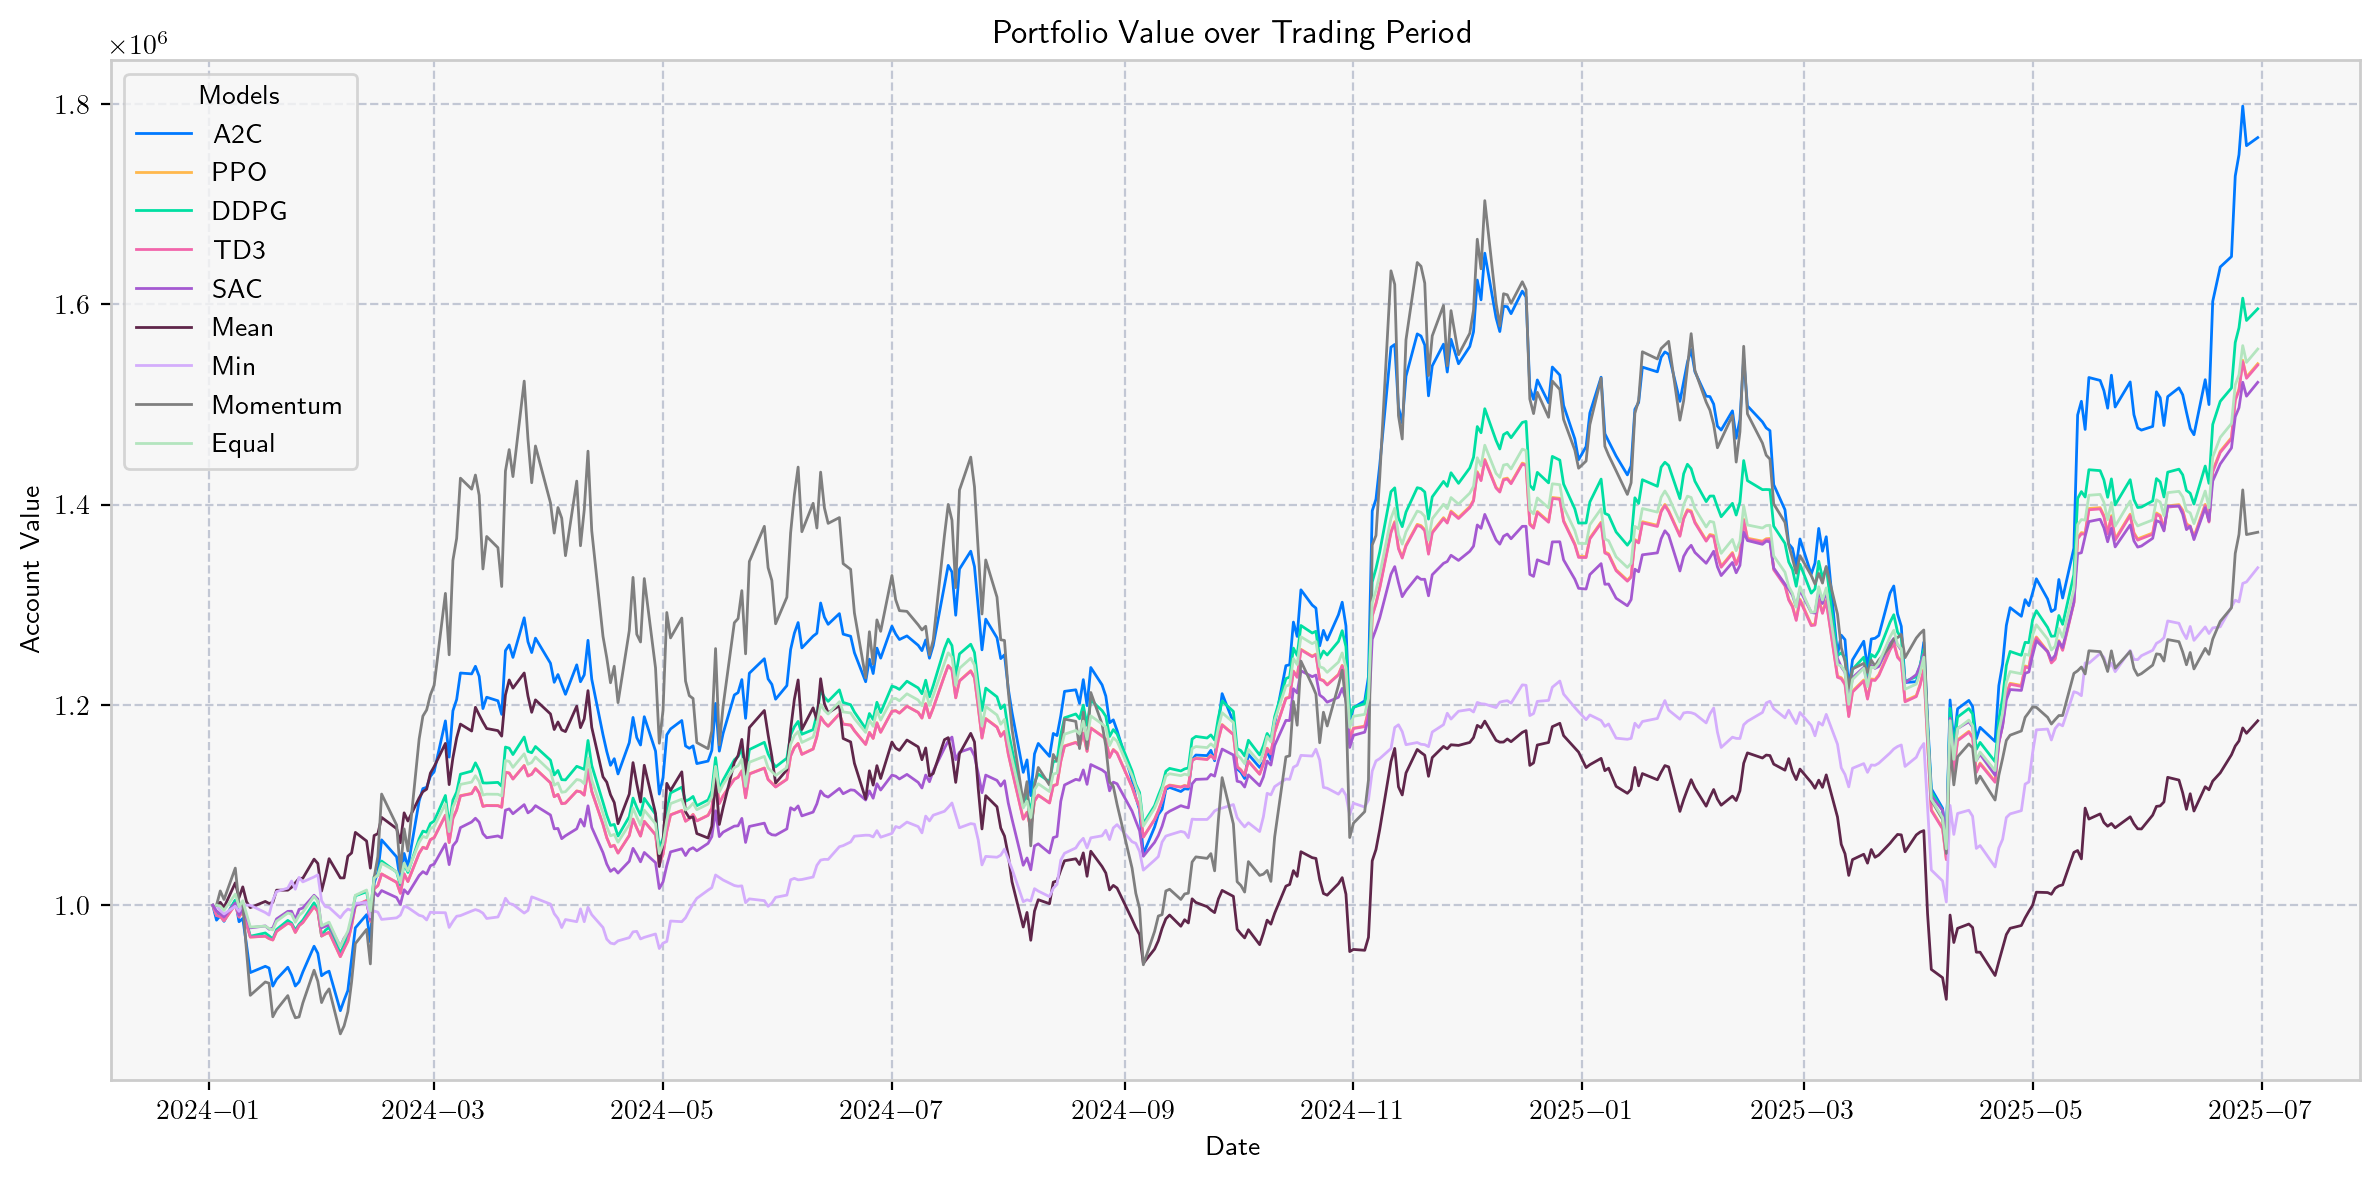

In [ ]:
benchmark_visualiser.compare_account_value(
    df_account, f"../{config.PLOT_DIR}", f"{config.TEST_NAME}_{USE_CASE}"
)

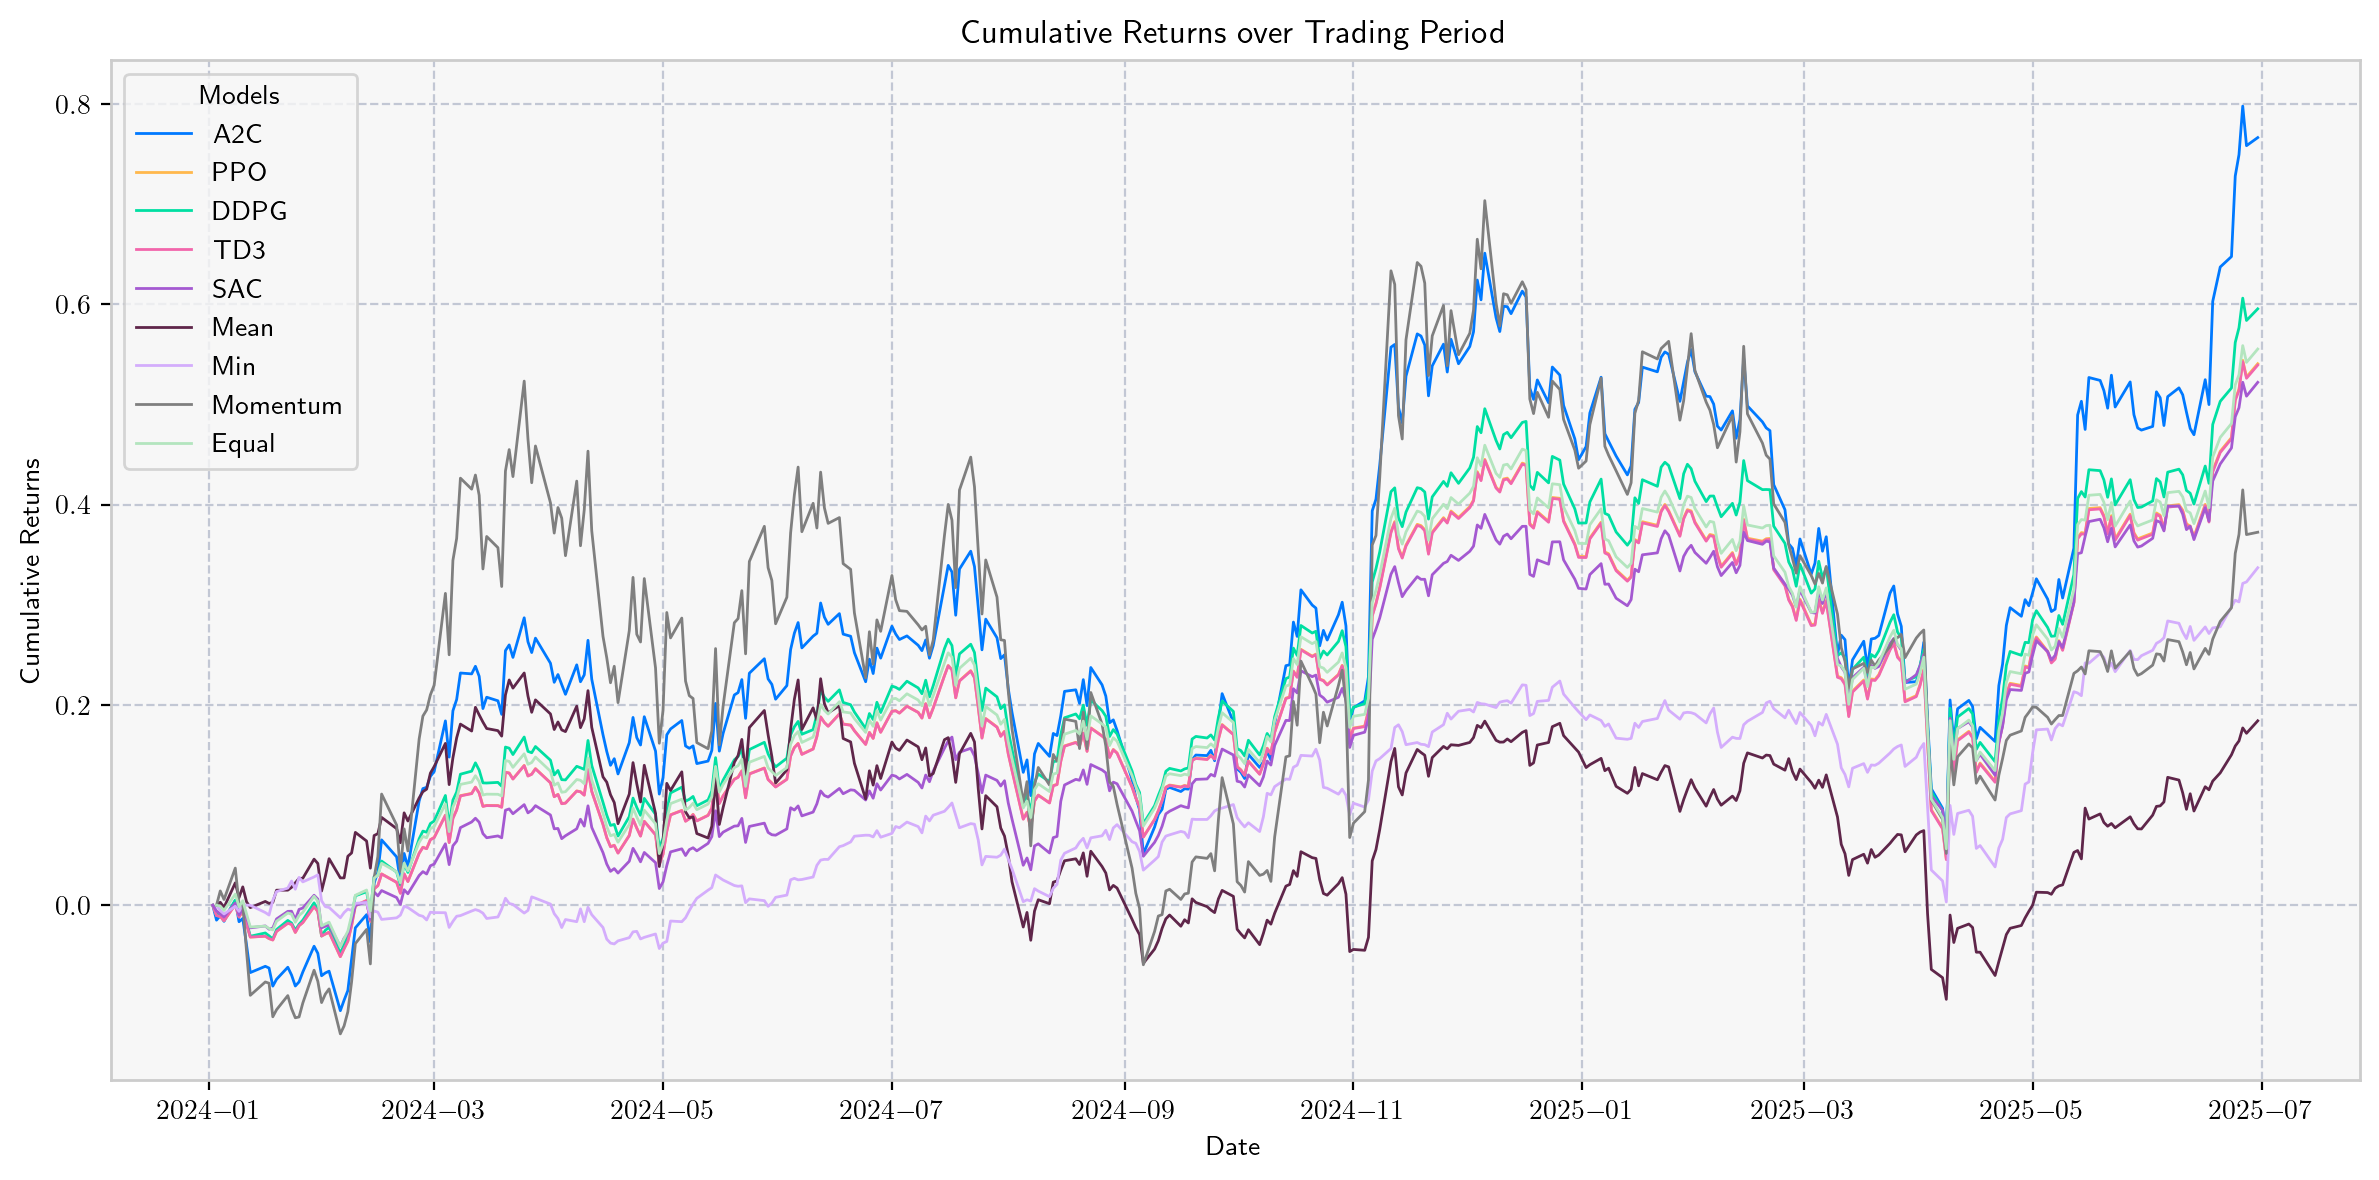

In [16]:
benchmark_visualiser.compare_cum_returns(
    df_account, f"../{config.PLOT_DIR}", f"{config.TEST_NAME}_{USE_CASE}"
)